# Establishing a stability on the news title with quorum

## Problem

- LLM's are not deterministic, and the news title is not stable. This can news headlines to change between runs.
- Different LLM models have different biases, and can censor or amplify certain news sources or topics.

## Solution

Use multiple LLM models to generate news titles, and select the most common one as the final title.

## Approach

1. Generate news titles using multiple LLM models.
2. Generate word vectors for each title.
3. Calculate the cosine similarity between each pair of titles.
4. If the similarity is above a certain threshold, consider the titles to be the same, and select the title with the highest quorum.
5. If the similarity is below the threshold, evaluate titles against the article content with NER and try to find the outlier(s).


In [166]:
%load_ext autoreload
%autoreload 2

from meri.utils import setup_logging

import logging

setup_logging()
logging.basicConfig(level=logging.DEBUG)
logging.getLogger("trafilatura").setLevel(logging.DEBUG)


Attempting to instrument while already instrumented positional_args=()
Attempting to instrument while already instrumented positional_args=()
Attempting to instrument while already instrumented positional_args=()
Attempting to instrument while already instrumented positional_args=()
Attempting to instrument while already instrumented positional_args=()
Attempting to instrument while already instrumented positional_args=()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Approach testing – similarity

Test sentence tranformers and clustering methods against static data.

Notice that this dataset is a bad example, as the event is most likely in different datasets.

In [167]:
# Test data
headlines = [
    # emphasizes the student movement and its suppression.
    "Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown",
    # focuses on the military’s role in ending the protests.
    "Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations",
    # ses stronger language ("Massacre") to highlight the violence and casualties.
    "1989 Tiananmen Square Massacre: Government Forces Clash with Protesters in Beijing"
]

alternative_headlines = [
    # emphasizing the student-led movement and military response.
    "Tiananmen Square 1989: Student Protests Met with Military Force in Beijing",
    # focusing on military suppression.
    "Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square",
    # emphasizing the violent clash.
    "Tiananmen Square Massacre: Government Troops Open Fire on Protesters in 1989"
]

wording_variants = [
    # emphasizing the student-led movement and crackdown.
    "1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention",
    # focusing on the military suppression of demonstrators.
    "Chinese Troops Disperse Pro-Democracy Protesters in Tiananmen Square, 1989",
    # highlighting government force and violence.
    "Tiananmen Square Tragedy: Beijing Crackdown on Protesters Turns Violent in 1989"
]

approved_headlines = [
    "Beijing Restores Order After Unrest in Tiananmen Square",
    "Chinese Authorities Take Decisive Action to End Riots in Capital",
    "Government Ensures National Stability Amid Social Disturbance in 1989",
]

allok_headlines = [
    # a normal government action with no disruption.
    "Routine Security Measures Implemented in Beijing, Daily Life Unaffected",
    # Implying no major event took place.
    "Calm Prevails in Tiananmen Square as Citizens Go About Their Day",
    # Downplays the scale and significance of the protests.
    "Beijing Maintains Social Harmony Amid Minor Public Gatherings"
]

offtopic_headlines = [
    "China Hosts International Conference on Climate Change",
    "Aliens Land in Beijing, Establish Contact with Chinese Government",
    "Trump Announces New Sanctions on Chinese Imports"
]

article = """
Beijing, June 4, 1989 – What began as a peaceful student-led movement advocating for political reform and greater freedoms ended in a violent military crackdown as Chinese government forces moved into Tiananmen Square in the early hours of June 4.

For weeks, tens of thousands of demonstrators, including students, intellectuals, and workers, had occupied the square, calling for democratic reforms, freedom of speech, and an end to government corruption. The protests, initially sparked by the death of pro-reform leader Hu Yaobang, grew into one of the largest demonstrations in China’s history.

As negotiations between protesters and the government stalled, authorities declared martial law. On the night of June 3 and into June 4, the Chinese military, equipped with tanks and armed troops, advanced on Tiananmen Square. Eyewitnesses reported gunfire, chaotic clashes, and casualties among unarmed civilians. While the exact death toll remains disputed, estimates range from several hundred to possibly thousands.

The Chinese government has since suppressed discussion of the events, censoring information in media and online platforms. The incident remains a highly sensitive topic in China, while globally, it stands as a symbol of the struggle for democratic rights and government accountability.
"""

grouped_headlines = {
    "Headlines": headlines,
    "Alternative Headlines": alternative_headlines,
    "Wording Variants": wording_variants,
    "Approved Headlines": approved_headlines,
    "All-OK Headlines": allok_headlines,
    "Off-Topic Headlines": offtopic_headlines
}

aspected_headlines = {
    "Student Movement": [headlines[0], alternative_headlines[0], wording_variants[0]],
    "Military Suppression": [headlines[1], alternative_headlines[1], wording_variants[1]],
    "Violent Clash": [headlines[2], alternative_headlines[2], wording_variants[2]]
}

headlines_list = headlines + alternative_headlines + wording_variants + approved_headlines + allok_headlines + offtopic_headlines


In [168]:
# Setup sentence-transformers
# Install sentence-transformers
#!pip install torch --index-url https://download.pytorch.org/whl/cpu
#!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()
Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()
Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()
Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()
Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()
Load pretrained SentenceTransformer: all-MiniLM-L6-v2 positional_args=()


In [169]:
import numpy as np

def mean_cosine_similarity(similarities):
    # Calculate the average cosine similarity between the headlines
    # Drop all diagonal values (i.e., self-similarities)
    mask = ~np.eye(similarities.shape[0], dtype=bool)
    return similarities[mask].mean()

def comp_similarity():
    """
    Compute the average similarity between all headlines.
    """

    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)
    print(f"There is a total of {embeddings.shape[0]} headlines and each headline is represented by a {embeddings.shape[1]}-dimensional vector.")

    # Compute cosine similarities between headlines
    similarities = model.similarity(embeddings, embeddings)
    average_similarity = mean_cosine_similarity(similarities)
    print(f"The average cosine similarity between the headlines is {average_similarity:.2f}.")


def comp_group_similarity():
    """
    Similarity between headlines within each group and aspect.
    """

    # Compute embeddings for each group of headlines
    grouped_embeddings = {k: model.encode(v, show_progress_bar=False) for k, v in grouped_headlines.items()}
    print("\nSimilarity between headlines within each group:")
    # Compute cosine similarities between headlines within each group
    grouped_similarities = {k: model.similarity(v, v) for k, v in grouped_embeddings.items()}
    for group, similarities in grouped_similarities.items():
        group_mean = mean_cosine_similarity(similarities)
        print(f" - {group}: {group_mean:.2f}")

    # Compute for each aspect
    aspect_embeddings = {k: model.encode(v, show_progress_bar=False) for k, v in aspected_headlines.items()}
    aspect_similarities = {k: model.similarity(v, v) for k, v in aspect_embeddings.items()}
    print("\nSimilarity between headlines within each aspect:")
    for aspect, similarities in aspect_similarities.items():
        aspect_mean = mean_cosine_similarity(similarities)
        print(f" - {aspect}: {aspect_mean:.2f}")

comp_similarity()
comp_group_similarity()

There is a total of 18 headlines and each headline is represented by a 384-dimensional vector.
The average cosine similarity between the headlines is 0.55.

Similarity between headlines within each group:
 - Headlines: 0.74
 - Alternative Headlines: 0.74
 - Wording Variants: 0.79
 - Approved Headlines: 0.34
 - All-OK Headlines: 0.43
 - Off-Topic Headlines: 0.42

Similarity between headlines within each aspect:
 - Student Movement: 0.91
 - Military Suppression: 0.78
 - Violent Clash: 0.89


KMeans Clustering:
Optimal number of clusters: 1 (Elbow Method) / 2 (Silhouette Score)
Optimal number of clusters differ between the elbow method and silhouette score.


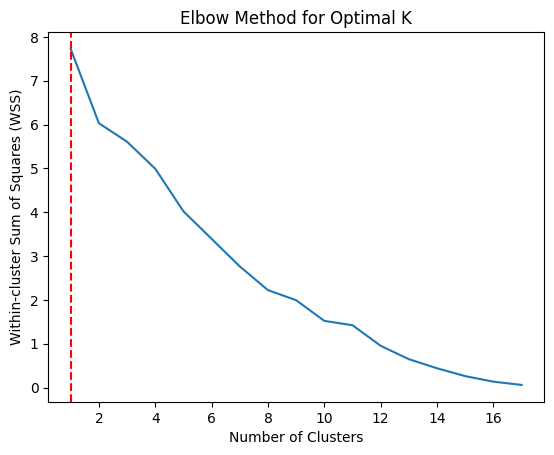

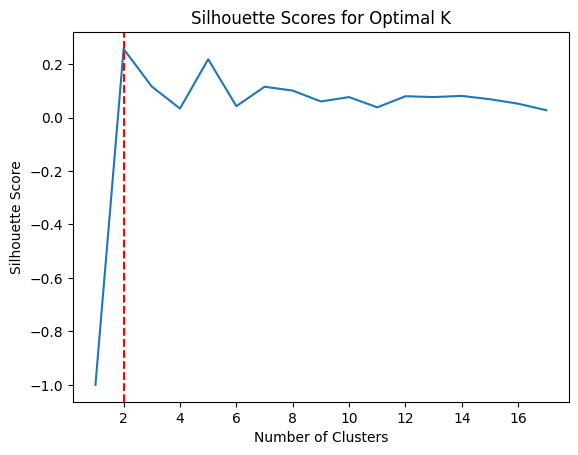

In [170]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

MIN_NUM_CLUSTERS = 1
MAX_NUM_CLUSTERS = len(headlines_list) - 1

def kmeans_cluster():
    """
    Cluster the headlines using KMeans.
    """
    
    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)

    # Determine the optimal number of clusters
    clusters = []
    inertias = []
    silhouettes = [-1]
    for i in range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++')
        cluster_labels = kmeans.fit_predict(embeddings)
        clusters.append(cluster_labels)
        inertias.append(kmeans.inertia_)

        # Skip silhouette score for 1 cluster
        if i == 1: continue

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouettes.append(silhouette_avg)

    # Find the optimal number of clusters using the elbow method
    elbow = np.diff(inertias)
    opt_elbow = elbow.argmin() + 1

    # Optimal using silhouette score
    opt_silh = silhouettes.index(max(silhouettes)) + 1

    print(f"Optimal number of clusters: {opt_elbow} (Elbow Method) / {opt_silh} (Silhouette Score)")

    # If the optimals are the same, show the clustering results
    if opt_elbow == opt_silh:
        print(f"Clustering headlines into {opt_elbow} clusters:")
        for i in range(opt_elbow):
            cluster = np.array(headlines_list)[clusters[opt_elbow] == i]
            print(f"Cluster {i + 1}: {cluster}")
    else:
        print("Optimal number of clusters differ between the elbow method and silhouette score.")
    
    # Plot the inertia values
    plt.plot(range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1), inertias)
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.axvline(opt_elbow, linestyle='--', color='r', label='Optimal K')
    plt.show()

    # Plot the silhouette scores
    plt.plot(range(MIN_NUM_CLUSTERS, MAX_NUM_CLUSTERS + 1), silhouettes)
    plt.title('Silhouette Scores for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.axvline(opt_silh, linestyle='--', color='r', label='Optimal K')
    plt.show()


print("KMeans Clustering:")
kmeans_cluster()


In [172]:
from collections import Counter
from sklearn.cluster import DBSCAN
# Apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
# DBSCAN has two main parameters: eps (maximum distance between points to be considered neighbors), min_samples (min number of samples to form a dense region)
# headlines_list = [
#     "Government Faces Backlash Over New Tax Policy",
#     "New Tax Policy Announced: How It Affects You",
#     "Citizens Protest Against Controversial Tax Changes",
#     "Tax Reform Causes Public Uproar",
#     "Tax Law Passed Amid Public Protests",
#     "New Tax Policy Could Have Major Impact on Families"
# ]

def dbscan_cluster():
    """
    Cluster the headlines using DBSCAN.
    """

    # Compute embeddings for headlines
    embeddings = model.encode(headlines_list, show_progress_bar=False)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=2, metric="cosine")
    labels = dbscan.fit_predict(embeddings)
    print("DBSCAN Labels:", labels)

    # Get the number of clusters
    num_clusters = Counter(labels)
    print(f"Number of clusters: {len(num_clusters)}")

    
print("DBSCAN Clustering:")
dbscan_cluster()

DBSCAN Clustering:
DBSCAN Labels: [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1  0  0]
Number of clusters: 2
Cluster 1: ['Tiananmen Square Protests: 1989 Student-Led Movement Ends in Military Crackdown'
 "Beijing's Tiananmen Square: Chinese Military Suppresses Pro-Democracy Demonstrations"
 '1989 Tiananmen Square Massacre: Government Forces Clash with Protesters in Beijing'
 'Tiananmen Square 1989: Student Protests Met with Military Force in Beijing'
 'Chinese Army Cracks Down on Pro-Democracy Protests at Tiananmen Square'
 'Tiananmen Square Massacre: Government Troops Open Fire on Protesters in 1989'
 '1989 Tiananmen Square Protests: Student Demonstrations End in Military Intervention'
 'Chinese Troops Disperse Pro-Democracy Protesters in Tiananmen Square, 1989'
 'Tiananmen Square Tragedy: Beijing Crackdown on Protesters Turns Violent in 1989'
 'Beijing Restores Order After Unrest in Tiananmen Square'
 'Chinese Authorities Take Decisive Action to End Riots in Capital'
 'Calm Prevai

Extract Quantitative Features
Tools like TextBlob or VADER can provide:

    Polarity: A score ranging from -1 (negative) to 1 (positive). Headlines with extreme values may indicate bias.
    Subjectivity: A score from 0 (very objective) to 1 (very subjective). Lower subjectivity often suggests a more neutral tone.